In [1]:
#%pip install wget
import wget
url='https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/MRIs.zip'
wget.download(url)

'MRIs.zip'

In [2]:
import zipfile
with zipfile.ZipFile('MRIs.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [1]:
import torch
import os 
from pathlib import Path

path = Path('./MRIs')
imgs = [path/'MRIs'/i for i in os.listdir(path/'MRIs')]
ixs = [i.split('_')[-1] for i in os.listdir(path/'MRIs')]
masks = [path/'Segmentations'/f'segm_{ix}' for ix in ixs]

len(imgs), len(masks)

(425, 425)

In [4]:
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


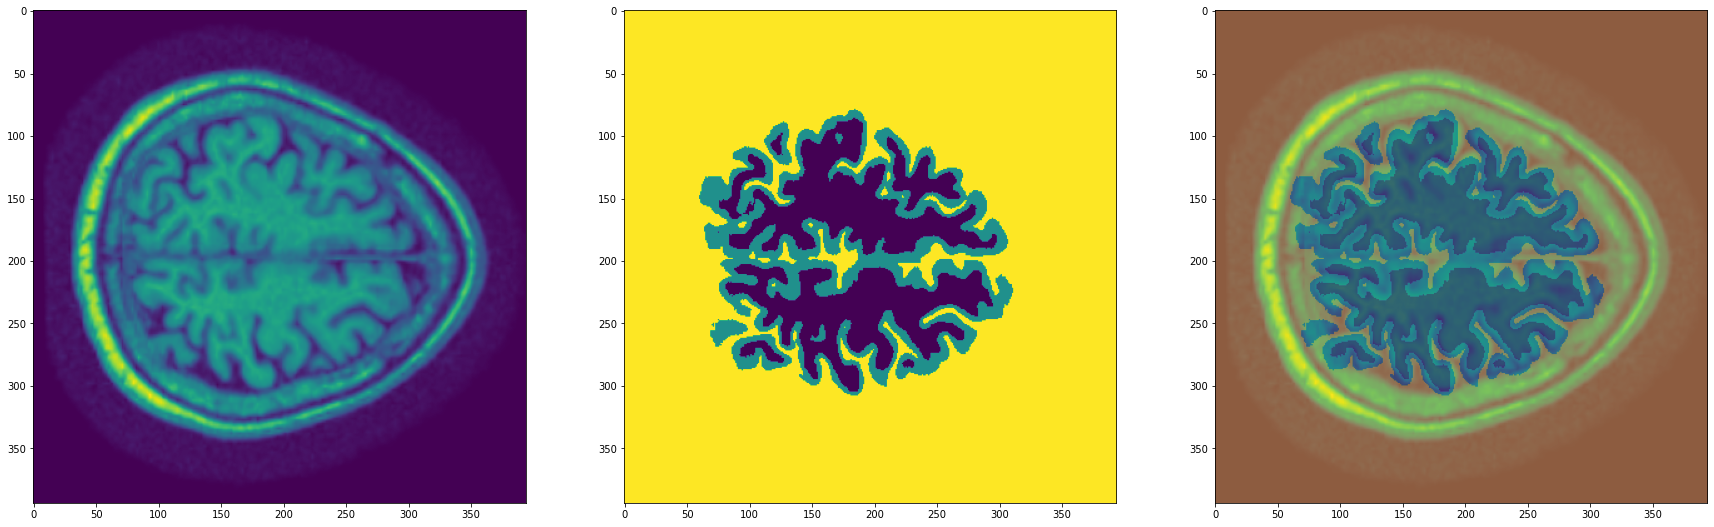

In [2]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
img = np.load(imgs[0])
mask = np.load(masks[0])
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(img)
ax3.imshow(mask, alpha=0.4)
plt.show()

In [4]:
mask_oh = (np.arange(3) == mask[...,None]).astype(np.float32) 
mask_oh.shape, mask_oh.dtype, mask_oh.max(), mask_oh.min()

((394, 394, 3), dtype('float32'), 1.0, 0.0)

In [5]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, n_classes=3):
    self.X = X
    self.y = y
    self.n_classes = n_classes

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    img = np.load(self.X[ix])
    mask = np.load(self.y[ix])
    img = torch.tensor(img).unsqueeze(0) 
    mask = (np.arange(self.n_classes) == mask[...,None]).astype(np.float32) 
    return img, torch.from_numpy(mask).permute(2,0,1)

In [6]:
dataset = {
    'train': Dataset(imgs[:-100], masks[:-100]),
    'test': Dataset(imgs[-100:], masks[-100:])
}

len(dataset['train']), len(dataset['test'])

(325, 100)

In [7]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=16, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=32, pin_memory=True)
}

imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

(torch.Size([16, 1, 394, 394]), torch.Size([16, 3, 394, 394]))

In [8]:
import torchvision
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=1):
        super().__init__()

        self.encoder = torchvision.models.resnet18(pretrained=True)           
        if in_ch != 3:
          self.encoder.conv1 = torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        #x_in = torch.tensor(x.clone())
        x_in = x.clone().detach() #or the same with .requires_grad_(True),
        x = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x, x_in)
        return x

In [9]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))  
        union = (_out | _labs).float().sum((1, 2))         
        iou = (intersection + SMOOTH) / (union + SMOOTH)  
        ious.append(iou.mean().item())
    return np.mean(ious) 

In [14]:
torch.cuda.is_available()

True

In [10]:
%pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 KB 2.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [16]:
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
      bar = tqdm(dataloader['train'])
      train_loss, train_iou = [], []
      model.train()
      for imgs, masks in bar:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        y_hat = model(imgs)
        loss = criterion(y_hat, masks)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, masks)
        train_loss.append(loss.item())
        train_iou.append(ious)
        bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
      hist['loss'].append(np.mean(train_loss))
      hist['iou'].append(np.mean(train_iou))
      bar = tqdm(dataloader['test'])
      test_loss, test_iou = [], []
      model.eval()
      with torch.no_grad():
        for imgs, masks in bar:
          imgs, masks = imgs.to(device), masks.to(device)
          y_hat = model(imgs)
          loss = criterion(y_hat, masks)
          ious = iou(y_hat, masks)
          test_loss.append(loss.item())
          test_iou.append(ious)
          bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
      hist['test_loss'].append(np.mean(test_loss))
      hist['test_iou'].append(np.mean(test_iou))
      print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
    return hist

In [20]:
model = UNetResnet()
hist = fit(model, dataloader, epochs=30)

test_loss 0.61400 test_iou 0.11384: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]



Epoch 1/30 loss 0.54842 iou 0.35569 test_loss 0.61400 test_iou 0.11384


test_loss 0.46595 test_iou 0.32603: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]



Epoch 2/30 loss 0.41156 iou 0.63051 test_loss 0.46595 test_iou 0.32603


test_loss 0.35860 test_iou 0.67310: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]



Epoch 3/30 loss 0.35889 iou 0.68531 test_loss 0.35860 test_iou 0.67310


test_loss 0.31665 test_iou 0.70159: 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]



Epoch 4/30 loss 0.31941 iou 0.71243 test_loss 0.31665 test_iou 0.70159


test_loss 0.28425 test_iou 0.72950: 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]



Epoch 5/30 loss 0.28677 iou 0.72813 test_loss 0.28425 test_iou 0.72950


test_loss 0.25791 test_iou 0.73272: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]



Epoch 6/30 loss 0.25749 iou 0.74634 test_loss 0.25791 test_iou 0.73272


test_loss 0.23760 test_iou 0.70675: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]



Epoch 7/30 loss 0.23367 iou 0.75087 test_loss 0.23760 test_iou 0.70675


test_loss 0.20743 test_iou 0.75438: 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]



Epoch 8/30 loss 0.21137 iou 0.76567 test_loss 0.20743 test_iou 0.75438


test_loss 0.19071 test_iou 0.75497: 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]



Epoch 9/30 loss 0.19155 iou 0.77865 test_loss 0.19071 test_iou 0.75497


test_loss 0.17434 test_iou 0.75938: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]



Epoch 10/30 loss 0.17400 iou 0.78984 test_loss 0.17434 test_iou 0.75938


test_loss 0.15655 test_iou 0.77051: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]



Epoch 11/30 loss 0.15877 iou 0.79658 test_loss 0.15655 test_iou 0.77051


test_loss 0.14813 test_iou 0.76005: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]



Epoch 12/30 loss 0.14275 iou 0.81939 test_loss 0.14813 test_iou 0.76005


test_loss 0.13591 test_iou 0.77529: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]



Epoch 13/30 loss 0.13070 iou 0.82588 test_loss 0.13591 test_iou 0.77529


test_loss 0.12469 test_iou 0.79988: 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]



Epoch 14/30 loss 0.11944 iou 0.83578 test_loss 0.12469 test_iou 0.79988


test_loss 0.11918 test_iou 0.78365: 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]



Epoch 15/30 loss 0.10902 iou 0.84836 test_loss 0.11918 test_iou 0.78365


test_loss 0.10937 test_iou 0.79882: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]



Epoch 16/30 loss 0.10140 iou 0.85059 test_loss 0.10937 test_iou 0.79882


test_loss 0.10378 test_iou 0.80295: 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]



Epoch 17/30 loss 0.09399 iou 0.85657 test_loss 0.10378 test_iou 0.80295


test_loss 0.09624 test_iou 0.81275: 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]



Epoch 18/30 loss 0.08746 iou 0.86147 test_loss 0.09624 test_iou 0.81275


test_loss 0.09699 test_iou 0.78843: 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]



Epoch 19/30 loss 0.08048 iou 0.87161 test_loss 0.09699 test_iou 0.78843


test_loss 0.08768 test_iou 0.80669: 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]



Epoch 20/30 loss 0.07650 iou 0.86878 test_loss 0.08768 test_iou 0.80669


test_loss 0.08559 test_iou 0.81416: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]



Epoch 21/30 loss 0.07112 iou 0.87732 test_loss 0.08559 test_iou 0.81416


test_loss 0.08218 test_iou 0.81279: 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]



Epoch 22/30 loss 0.06596 iou 0.88550 test_loss 0.08218 test_iou 0.81279


test_loss 0.07711 test_iou 0.82336: 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]



Epoch 23/30 loss 0.06215 iou 0.88761 test_loss 0.07711 test_iou 0.82336


test_loss 0.07555 test_iou 0.82090: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]



Epoch 24/30 loss 0.05829 iou 0.89362 test_loss 0.07555 test_iou 0.82090


test_loss 0.08468 test_iou 0.78441: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]



Epoch 25/30 loss 0.05712 iou 0.88594 test_loss 0.08468 test_iou 0.78441


test_loss 0.07423 test_iou 0.80775: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]



Epoch 26/30 loss 0.05912 iou 0.86706 test_loss 0.07423 test_iou 0.80775


test_loss 0.07125 test_iou 0.82036: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]



Epoch 27/30 loss 0.05173 iou 0.89333 test_loss 0.07125 test_iou 0.82036


test_loss 0.07333 test_iou 0.80009: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]



Epoch 28/30 loss 0.04852 iou 0.89933 test_loss 0.07333 test_iou 0.80009


test_loss 0.06892 test_iou 0.81769: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]



Epoch 29/30 loss 0.04566 iou 0.90471 test_loss 0.06892 test_iou 0.81769


test_loss 0.06491 test_iou 0.82659: 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]


Epoch 30/30 loss 0.04370 iou 0.90612 test_loss 0.06491 test_iou 0.82659


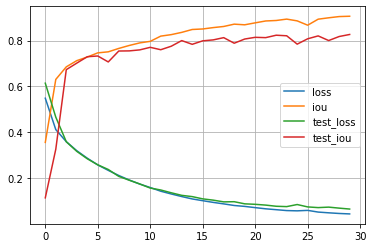

In [21]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

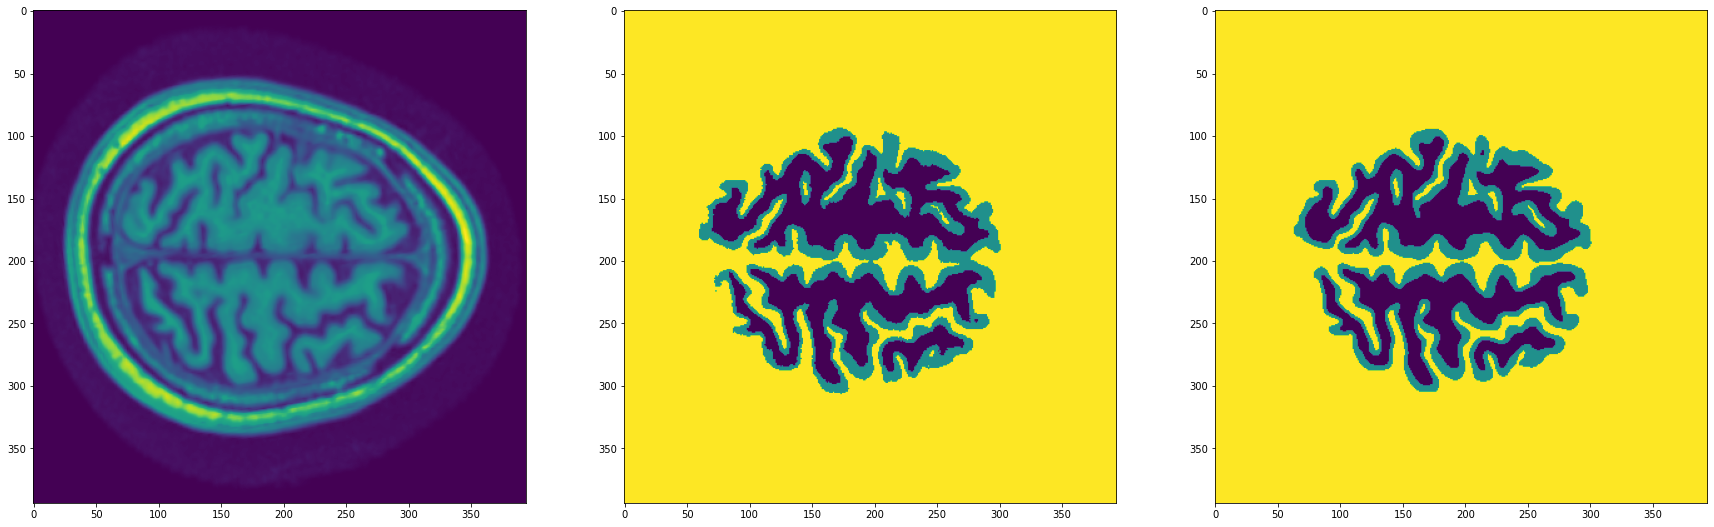

In [22]:
import random

model.eval()
with torch.no_grad():
    ix = random.randint(0, len(dataset['test'])-1)
    img, mask = dataset['test'][ix]
    output = model(img.unsqueeze(0).to(device))[0]
    pred_mask = torch.argmax(output, axis=0)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img.squeeze(0))
ax2.imshow(torch.argmax(mask, axis=0))
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()